In [1]:
import json
import os
import matplotlib.pyplot as plt
%matplotlib widget

from la_forge.core import Core as co
from la_forge.utils import bayes_fac

import sys
sys.path += ['/home/frh7/FR_Targeted_Searches']
from tsutils.utils import calc_log10_strain

In [2]:
with open('../target_priors_v2/target_index.json', 'r') as fp:
    target_index = json.load(fp)
target_names = {int(key): ' '.join(val[:-5].split('_')[1:]) for key, val in target_index.items()}

In [3]:
def target_path(target_num, mass_prior):
    target_idx = f'{target_num:03d}'
    target_fname = target_index[target_idx][:-5]
    dpath = f'/gpfs/gibbs/project/mingarelli/frh7/FR_Targeted_Searches/data/chains/ng15_v1p1/{target_fname}_{mass_prior}_cfgw_pt_v4/'
    return dpath

def load_chain(target_num, mass_prior):
    dpath = target_path(target_num, mass_prior)
    post_info_path = dpath+'/postinfo.json'
    if os.path.exists(post_info_path):
        with open(post_info_path) as fp:
            post_info = json.load(fp)
        if 'burn' in post_info.keys():
            burn = post_info['burn']
        else:
            print('burn in not set! Setting to 0.')
            burn = 0
    else:
        print('First time loading chain. Setting burn in to 0.')
        burn = 0
        with open(post_info_path, 'w') as fp:
            json.dump({}, fp)

    chain = co(dpath, burn=burn)
    constant_priorpath = dpath + '/constant_priors.json'
    with open(constant_priorpath) as f:
        constant_priors = json.load(f)
    return chain, constant_priors

def update_post_info(update_dict):
    dpath = target_path(target_num, mass_prior)
    post_info_path = dpath+'/postinfo.json'
    with open(post_info_path) as fp:
            post_info = json.load(fp)
    post_info.update(update_dict)
    with open(post_info_path, 'w') as fp:
        json.dump(post_info, fp)

In [4]:
# 8, 14 (2 repeats)
# 24, 25, 27-31, 33-45 (20)
# 46, 48-50, 52-56, 58-68 (20)
# 37, 60 had BF ~ 1

# burn in set and confirmed for:
# 8, 14, 24, 25, 27, 28, 29, 30, 31, 33, 34, 35u, 36u, 37u, 38u, 39u, 40u, 41u, 42u, 43u, 44u, 45u
# 46, 48u, 49u, 50u, 52u, 53u, 54u, 55u, 56u, 58, 59u, 60u, 61u, 62u, 63u, 64u, 65u, 66u, 67u, 68u
# 203

# New ones to do:
# 69-74
# 75-79,81-82,84-86

# Done from these:
# 69-74
# 75-79, 81-82, 84-86

# New ones to do:
# 87-92
# 93-99,101,104,105,107,110

# Done from these:
# 87-92
# 93-99, 101, 104, 105, 107, 110

# 87-ul is a little screwed up

In [6]:
target_num = 203
mass_prior = 'det'

chain, constant_priors = load_chain(target_num, mass_prior)
target = target_names[target_num]

In [7]:
log10dist = constant_priors['log10_dist']
cos_gwtheta = constant_priors['cos_gwtheta']
gwphi = constant_priors['gwphi']
log10_fgw = constant_priors['log10_fgw']
print(log10_fgw)
print(10**log10_fgw)

log10_strain = calc_log10_strain(chain('log10_mc'), log10_fgw, log10dist)

-7.458977538359123
3.4755413642250575e-08


### Summary Traces

In [8]:
temp_burn = 1_000
chain.set_burn(temp_burn)

In [9]:
log10_strain = calc_log10_strain(chain('log10_mc'), log10_fgw, log10dist)

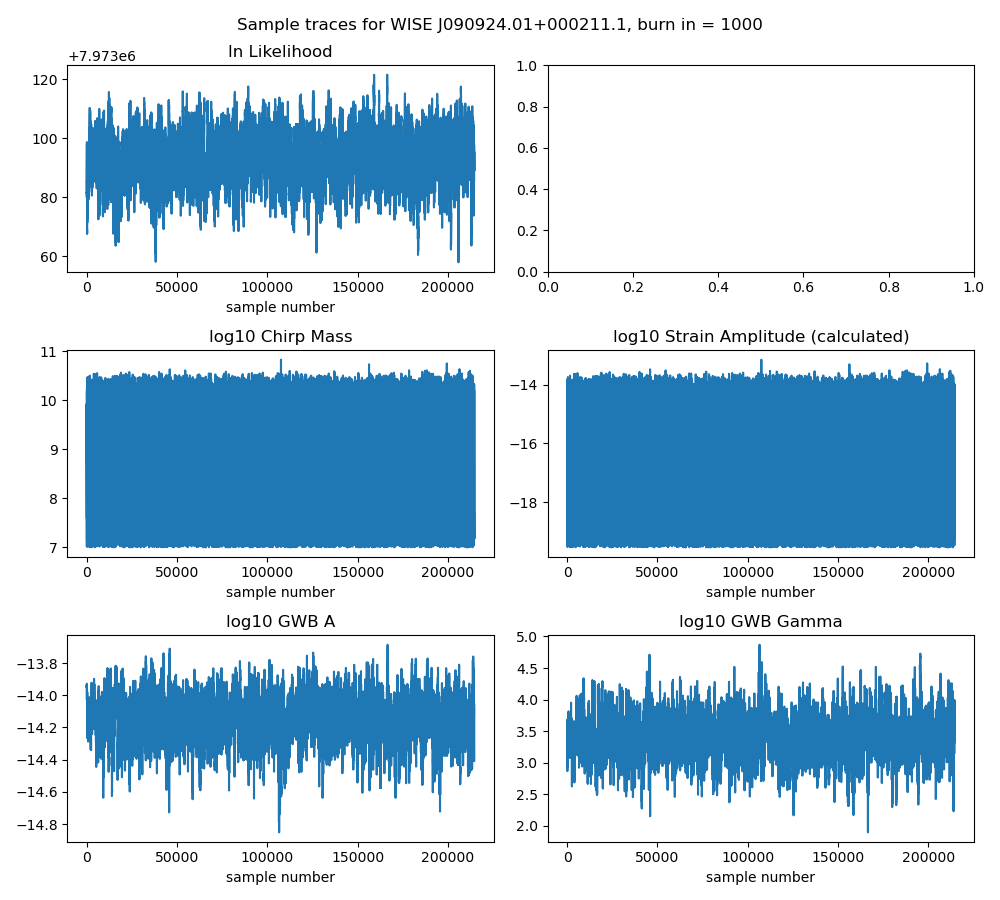

In [10]:
plt.close('all')
fig, ax = plt.subplots(3, 2, figsize=(10, 9))
fig.suptitle(f'Sample traces for {target}, burn in = {chain.burn:n}')

ax[0, 0].set_title('ln Likelihood')
ax[0, 0].plot(chain('lnlike'))
ax[0, 0].set_xlabel('sample number')

ax[1, 0].set_title('log10 Chirp Mass')
ax[1, 0].plot(chain('log10_mc'))
ax[1, 0].set_xlabel('sample number')

ax[1, 1].set_title('log10 Strain Amplitude (calculated)')
ax[1, 1].plot(log10_strain)
ax[1, 1].set_xlabel('sample number')

ax[2, 0].set_title('log10 GWB A')
ax[2, 0].plot(chain('crn_log10_A'))
ax[2, 0].set_xlabel('sample number')

ax[2, 1].set_title('log10 GWB Gamma')
ax[2, 1].plot(chain('gamma_crn'))
ax[2, 1].set_xlabel('sample number')

fig.tight_layout()

In [32]:
update_post_info({'burn': temp_burn})

In [12]:
log10_mc_min = float(chain.priors[chain.params.index('log10_mc')].split('=')[1].split(',')[0])
log10_mc_max = float(chain.priors[chain.params.index('log10_mc')].split('=')[2].split(')')[0])

pheight = 1/(log10_mc_max - log10_mc_min)

In [13]:
print(f'prior min: {log10_mc_min}')
print(f'prior max: {log10_mc_max}')

prior min: 7.0
prior max: 12.0


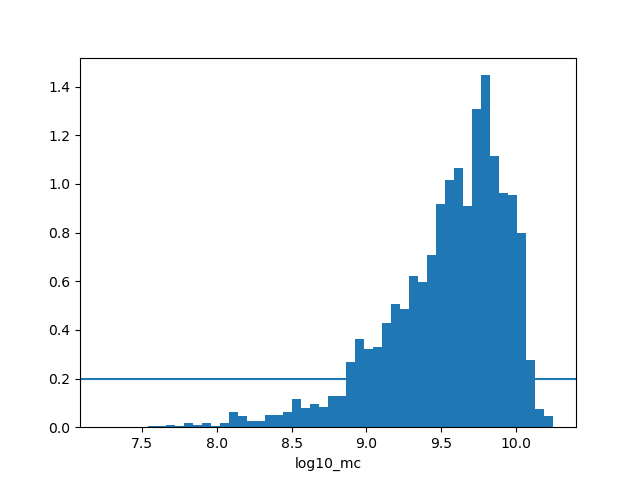

In [14]:
fig, ax = plt.subplots()
ax.hist(chain('log10_mc'), bins=50, density=True)
ax.set_xlabel('log10_mc')
ax.axhline(pheight)

In [237]:
bf_mass, bf_mass_sigma = bayes_fac(chain('log10_mc'), logAmin=log10_mc_min, logAmax=log10_mc_max)
print(f'({target_num}) {target} Bayes Factor: {bf_mass:.2f} ± {bf_mass_sigma:.2f}')

(203) WISE J090924.01+000211.1 Bayes Factor: 0.90 ± 0.04


In [15]:
ul = chain.credint('log10_mc', onesided=True, interval=95)
print(f'({target_num}) {target} Upper limit: {10**ul:.2e}')

(52) FBQS J17239+3748 Upper limit: 1.09e+10
